<a href="https://colab.research.google.com/github/MitraDP/Detection-of-Surface-Defects-in-Magnetic-Tile-Images/blob/master/SurfaceDefectDetection_MagneticTile.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Surface Defect Detection of Magnetic Tile

##Install the NVIDIA System Management Interface


In [27]:
# !ls -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !nvidia-smi
# !nvcc --version

##Download datasets

In [28]:
# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
# %%capture
# !wget -O data.zip https://github.com/abin24/Magnetic-tile-defect-datasets./archive/master.zip
# !unzip data.zip

In [30]:
# !mv Magnetic-tile-defect-datasets.-master data

##Library imports and the environment setting

In [31]:
# %%capture
import numpy as np
import pandas as pd
              
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile, Image
#ImageFile.LOAD_TRUNCATED_IMAGES = True

# !pip install torch
# !pip install torchvision
# !pip install torchsummary
import torch
import torchvision.models as models
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.optim as optim

import os
from glob import glob
import random
from random import shuffle
from tqdm import tqdm

# !pip install torch-lr-finder
from torch_lr_finder import LRFinder

In [32]:
from transforms import Resize, Rotate, VerticalFlip, HorizontalFlip, Normalize, ToTensor
from dataset import DefectDetectionDataset
from loss import WeightedBCELoss, TverskyLoss
from unet import UNet_2D
from metrics import performance_metrics 
from train import train_2D
from inference import plot_prediction_results, get_inference_performance_metrics

In [33]:
#check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available. Training on GPU ...')

CUDA is available. Training on GPU ...


In [34]:
##Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(51)

##Set the parameters

In [35]:
# batch_size = 32    # batch_size for the train and validation set
batch_size = 16
test_batch_size =1 # batch_size for the test set
num_workers = 0
n_epochs = 200
optimizer_type = 'Adam' """Either Adam or SGD, adjust the learning rate in the
                           "Specify the loss function and optimizer" section"""
threshold = 0.5   # Threshold value to create binary image 
lr_find = False   # Set to True to find the maximum learning rate
criterion_type = 'TverskyLoss'  """ Adjust the penalties in the "Specify the loss 
                                  function and optimizer" section"""
# criterion_type = 'WeightedBCE'  
# classes =['Blowhole', 'Crack','Free'] # classes/labels
# split_ratio = [0.70, 0.10, 0.20]      # A list of the (train,val,test) split ratio

## Dataset

In [36]:
# partition = partitioning(split_ratio)

In [37]:
# # Construct the transformed dataset
# surface_defect_dataset ={}
# for p in ['train', 'val', 'test']:
#     surface_defect_dataset[p] = SurfaceDefectDetectionDataset (partition[p], p)

In [38]:
image_path = {}
for c in ['set1', 'set2']:
    image_path[c] = glob('dataset/' + c + '/*.jpeg',recursive=True)

# fucai_defect_dataset ={}
# for p in ['set1', 'set2']:
#     fucai_defect_dataset[p] = DefectDetectionDataset (image_path[p], p)

### Visualize sample images along with their masks

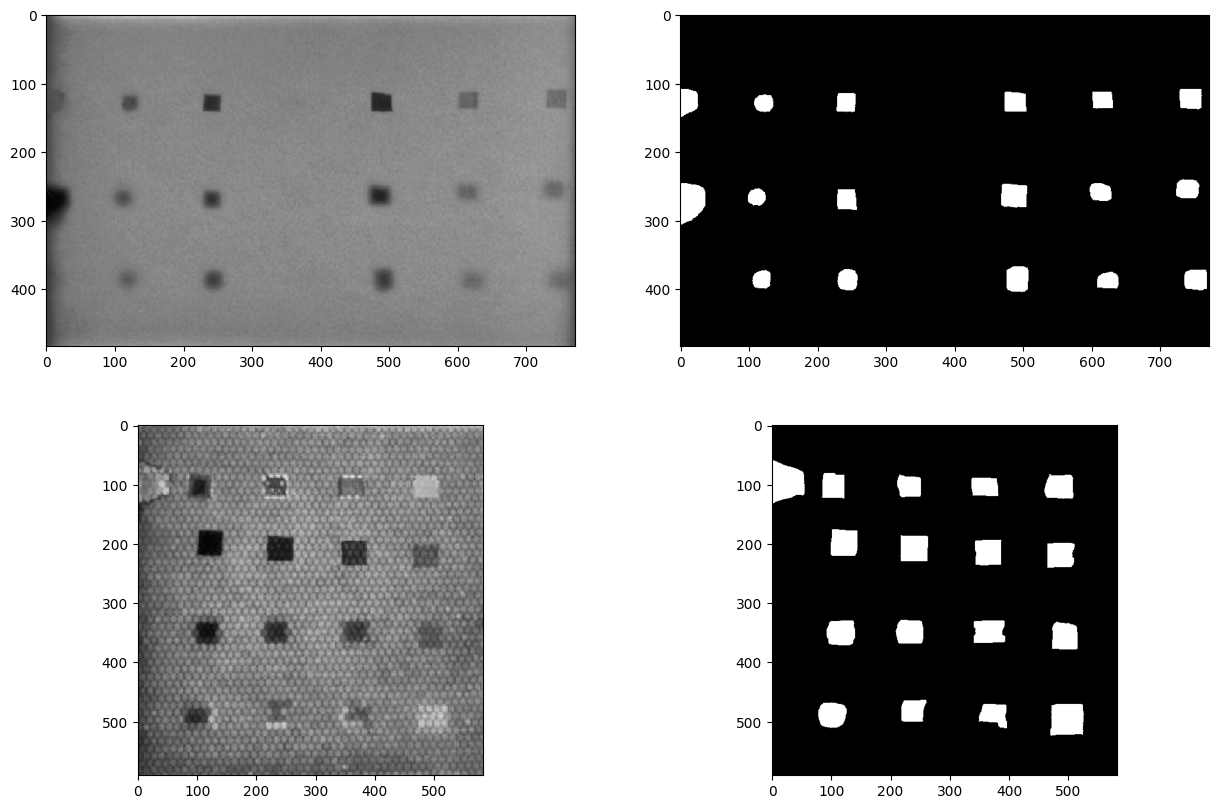

In [39]:
vis_path=['dataset/set1/a1','dataset/set1/b1']
#Define the size of images
fig =  plt.figure(figsize=(15, 10))
n=len(vis_path)
for i, im_path in enumerate(vis_path):
    ax = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(Image.open(im_path+'.jpeg').convert('L'), cmap='gray')
    ax = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(Image.open(im_path+'.png').convert('L'), cmap='gray')

###Visualize transforms on sample images and masks


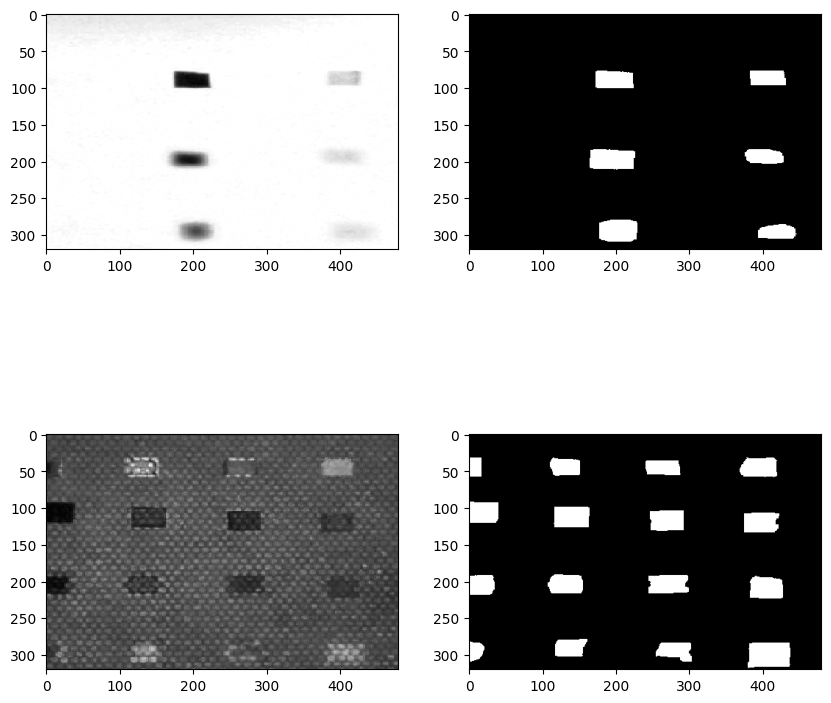

In [40]:
import torchvision.transforms
vis_path=['dataset/set1/a1','dataset/set1/b1']
#Define the size of images
fig =  plt.figure(figsize=(10, 10))
n=len(vis_path)
for i, im_path in enumerate(vis_path):
    image = Image.open(vis_path[i]+'.jpeg')
    mask = Image.open(vis_path[i]+'.png')

    rect = torchvision.transforms.RandomResizedCrop.get_params(image, scale=(0.3, 0.8), ratio=(0.5, 1.5))
    image = torchvision.transforms.functional.crop(image, *rect)
    mask = torchvision.transforms.functional.crop(mask, *rect)
    
    t1 = torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
    image = t1(image)
    image = image.convert('L')
    mask = mask.convert('L')

    re_t = torchvision.transforms.Resize((320, 480), torchvision.transforms.InterpolationMode.NEAREST)
    image = re_t(image)
    mask = re_t(mask)

    ax1 = fig.add_subplot(n,2,2*i+1) 
    plt.imshow(image, cmap='gray')
    ax2 = fig.add_subplot(n,2, 2*i+2)
    plt.imshow(mask, cmap='gray')


### Some stats about the dataset

In [41]:
#fing the range of height and width of train images
H = []
W = []
pair = []
for p in image_path['set1']:
  image = Image.open(p)
  W.append(image.size[0])
  H.append(image.size[1])
  pair.append(image.size)
print("maximum height:",max(H),"\tmaximum width:", max(W), "\tminimum height:", min(H), "\tminimum width:", min(W))

maximum height: 591 	maximum width: 771 	minimum height: 287 	minimum width: 523


In [42]:
fucai_defect_dataset ={}
fucai_defect_dataset['train'] = DefectDetectionDataset (image_path['set1'], 'train')
fucai_defect_dataset['val'] = DefectDetectionDataset (image_path['set2'], 'val')
fucai_defect_dataset['test'] = DefectDetectionDataset (image_path['set2'], 'test')

print('Length of train: ', len(fucai_defect_dataset['train']))
print('Length of val: ', len(fucai_defect_dataset['val']))
print('Length of test: ', len(fucai_defect_dataset['test']))

Length of train:  14
Length of val:  4
Length of test:  4


In [43]:
#find the weight of positive and negative pixels
positive_weight = 0
negative_weight = 0
total_pixels = 0
for _, target in fucai_defect_dataset['train']:
    positive_weight += ((target.cpu().numpy()) >= threshold).sum()
    negative_weight += ((target.cpu().numpy()) < threshold).sum()
    total_pixels += (320 * 480)
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive_weight = 0
negative_weight = 0
total_pixels = 0
for _, target in fucai_defect_dataset['val']:
    positive_weight += ((target.cpu().numpy()) >= threshold).sum()
    negative_weight += ((target.cpu().numpy()) < threshold).sum()
    total_pixels += (320* 480)
positive_weight /= total_pixels
negative_weight /= total_pixels
print('positive weight = ',positive_weight, '\tnegative weight = ', negative_weight)

positive weight =  0.060546875 	negative weight =  0.939453125
fuck
fuck
fuck
fuck
positive weight =  0.08946126302083333 	negative weight =  0.9105387369791667


## Batch and load data

In [44]:
# # Generators: load data in batches
# loaders={}
# loaders['train'] = torch.utils.data.DataLoader(surface_defect_dataset['train'], 
#                                                batch_size=batch_size,
#                                                shuffle = True,
#                                                num_workers=num_workers)
# loaders['val'] = torch.utils.data.DataLoader(surface_defect_dataset['val'], 
#                                              batch_size=batch_size,
#                                              shuffle=False, 
#                                              num_workers=num_workers)
# loaders['test'] = torch.utils.data.DataLoader(surface_defect_dataset['test'], 
#                                               batch_size= test_batch_size, 
#                                               shuffle=False, 
#                                               num_workers=num_workers)


In [45]:
# Generators: load data in batches
loaders={}
loaders['train'] = torch.utils.data.DataLoader(fucai_defect_dataset['train'], 
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=num_workers)
loaders['val'] = torch.utils.data.DataLoader(fucai_defect_dataset['val'], 
                                             batch_size=batch_size,
                                             shuffle=False, 
                                             num_workers=num_workers)
loaders['test'] = torch.utils.data.DataLoader(fucai_defect_dataset['test'], 
                                             batch_size=1,
                                             shuffle=False, 
                                             num_workers=num_workers)

## Obtain model architecture

In [46]:
# instantiate the unet
model = UNet_2D(1,1,32,0.2).cuda()
model.load_state_dict(torch.load('pretrained.pt'))

initialize
initialize
initialize
initialize
initialize
initialize
initialize
initialize
initialize


<All keys matched successfully>

In [47]:
# if GPU is available, move the model to GPU
if train_on_gpu:
    model.cuda()

In [48]:
summary(model, (1, 320, 480), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 32, 320, 480]             288
       BatchNorm2d-2         [16, 32, 320, 480]              64
              SiLU-3         [16, 32, 320, 480]               0
            Conv2d-4         [16, 32, 320, 480]           9,216
       BatchNorm2d-5         [16, 32, 320, 480]              64
              SiLU-6         [16, 32, 320, 480]               0
         MaxPool2d-7         [16, 32, 160, 240]               0
           Dropout-8         [16, 32, 160, 240]               0
            Conv2d-9         [16, 64, 160, 240]          18,432
      BatchNorm2d-10         [16, 64, 160, 240]             128
             SiLU-11         [16, 64, 160, 240]               0
           Conv2d-12         [16, 64, 160, 240]          36,864
      BatchNorm2d-13         [16, 64, 160, 240]             128
             SiLU-14         [16, 64, 1

## Specify the loss function and optimizer

In [49]:
if criterion_type == 'WeightedBCE':
    weight = np.array([negative_weight, positive_weight])
    weight = torch.from_numpy(weight)
    criterion = WeightedBCELoss(weights=weight)
else:
    criterion = TverskyLoss(1e-10,0.3,.7)
# Optimizer
# if optimizer_type == 'SGD':
#     optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# else:
#     optimizer = optim.Adam(model.parameters(), lr = 0.002)
# Optimizer
if optimizer_type == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=0.00005, momentum=0.9)
else:
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [50]:
"""
If lr_find is True, after running this cell, assign the scheduler's max_lr to 
the suggested maximum lr and then set lr_find to False in the "Set the parameters"
section. Set the lr in the optimizer 1/10 of max_lr. Then re_run the code. 
"""
if lr_find == False:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.02,
                                                    steps_per_epoch=len(loaders['train']),
                                                    epochs=n_epochs)     
else:
    #https://github.com/davidtvs/pytorch-lr-finder
    desired_batch_size, real_batch_size = batch_size, batch_size
    accumulation_steps = desired_batch_size // real_batch_size
    lr_finder = LRFinder(model, optimizer, criterion, device='cuda')
    lr_finder.range_test(loaders['train'], end_lr=1, num_iter=100, step_mode='exp')
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state"""

## Train and validate the model

In [51]:
model = train_2D(n_epochs, loaders, model, optimizer, criterion, train_on_gpu, 'model.pt')                

  0%|          | 0/201 [00:00<?, ?it/s]

=== Epoch #1 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...


  0%|          | 1/201 [00:08<29:52,  8.96s/it]

Epoch: 1 	Training Loss: 0.9137 	Validation Loss: 0.9791
Validation loss decreased.  Saving model ...
=== Epoch #2 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...


  1%|          | 2/201 [00:09<14:09,  4.27s/it]

Epoch: 2 	Training Loss: 0.9149 	Validation Loss: 0.9635
Validation loss decreased.  Saving model ...
=== Epoch #3 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 3 	Training Loss: 0.9143 	Validation Loss: 0.9510
Validation loss decreased.  Saving model ...


  1%|▏         | 3/201 [00:10<08:57,  2.71s/it]

=== Epoch #4 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 4 	Training Loss: 0.7910 	Validation Loss: 0.9444
Validation loss decreased.  Saving model ...


  2%|▏         | 4/201 [00:11<06:28,  1.97s/it]

=== Epoch #5 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 5 	Training Loss: 0.7892 	Validation Loss: 0.9414
Validation loss decreased.  Saving model ...


  2%|▏         | 5/201 [00:12<05:09,  1.58s/it]

=== Epoch #6 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 6 	Training Loss: 0.7227 	Validation Loss: 0.9302
Validation loss decreased.  Saving model ...


  3%|▎         | 6/201 [00:13<04:19,  1.33s/it]

=== Epoch #7 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 7 	Training Loss: 0.7992 	Validation Loss: 0.8753
Validation loss decreased.  Saving model ...


  3%|▎         | 7/201 [00:14<03:49,  1.18s/it]

=== Epoch #8 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 8 	Training Loss: 0.8416 	Validation Loss: 0.8282
Validation loss decreased.  Saving model ...


  4%|▍         | 8/201 [00:15<03:27,  1.07s/it]

=== Epoch #9 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 9 	Training Loss: 0.7008 	Validation Loss: 0.7909
Validation loss decreased.  Saving model ...


  4%|▍         | 9/201 [00:15<03:15,  1.02s/it]

=== Epoch #10 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 10 	Training Loss: 0.7117 	Validation Loss: 0.7461
Validation loss decreased.  Saving model ...


  5%|▍         | 10/201 [00:16<03:06,  1.02it/s]

=== Epoch #11 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 11 	Training Loss: 0.5326 	Validation Loss: 0.7107
Validation loss decreased.  Saving model ...


  5%|▌         | 11/201 [00:17<02:58,  1.07it/s]

=== Epoch #12 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 12 	Training Loss: 0.5760 	Validation Loss: 0.6721
Validation loss decreased.  Saving model ...


  6%|▌         | 12/201 [00:18<02:51,  1.10it/s]

=== Epoch #13 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 13 	Training Loss: 0.5449 	Validation Loss: 0.6265
Validation loss decreased.  Saving model ...


  6%|▋         | 13/201 [00:19<02:50,  1.10it/s]

=== Epoch #14 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 14 	Training Loss: 0.4998 	Validation Loss: 0.5994
Validation loss decreased.  Saving model ...


  7%|▋         | 14/201 [00:20<02:48,  1.11it/s]

=== Epoch #15 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 15 	Training Loss: 0.5350 	Validation Loss: 0.5578
Validation loss decreased.  Saving model ...


  7%|▋         | 15/201 [00:21<02:46,  1.12it/s]

=== Epoch #16 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 16 	Training Loss: 0.4535 	Validation Loss: 0.5272
Validation loss decreased.  Saving model ...


  8%|▊         | 16/201 [00:22<02:45,  1.11it/s]

=== Epoch #17 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 17 	Training Loss: 0.3628 	Validation Loss: 0.5059
Validation loss decreased.  Saving model ...


  8%|▊         | 17/201 [00:23<02:45,  1.11it/s]

=== Epoch #18 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 18 	Training Loss: 0.6071 	Validation Loss: 0.4607
Validation loss decreased.  Saving model ...


  9%|▉         | 18/201 [00:23<02:41,  1.14it/s]

=== Epoch #19 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 19 	Training Loss: 0.4475 	Validation Loss: 0.4386
Validation loss decreased.  Saving model ...


  9%|▉         | 19/201 [00:24<02:39,  1.14it/s]

=== Epoch #20 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 20 	Training Loss: 0.4483 	Validation Loss: 0.4246
Validation loss decreased.  Saving model ...


 10%|▉         | 20/201 [00:25<02:36,  1.16it/s]

=== Epoch #21 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 21 	Training Loss: 0.3623 	Validation Loss: 0.4123


 10%|█         | 21/201 [00:26<02:36,  1.15it/s]

Validation loss decreased.  Saving model ...
=== Epoch #22 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 22 	Training Loss: 0.4471 	Validation Loss: 0.4074
Validation loss decreased.  Saving model ...


 11%|█         | 22/201 [00:27<02:33,  1.16it/s]

=== Epoch #23 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 23 	Training Loss: 0.3408 	Validation Loss: 0.4123


 11%|█▏        | 23/201 [00:28<02:33,  1.16it/s]

=== Epoch #24 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 24 	Training Loss: 0.3579 	Validation Loss: 0.4165


 12%|█▏        | 24/201 [00:29<02:30,  1.17it/s]

=== Epoch #25 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 25 	Training Loss: 0.4508 	Validation Loss: 0.4128


 12%|█▏        | 25/201 [00:29<02:30,  1.17it/s]

=== Epoch #26 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 26 	Training Loss: 0.3865 	Validation Loss: 0.4024
Validation loss decreased.  Saving model ...


 13%|█▎        | 26/201 [00:30<02:32,  1.14it/s]

=== Epoch #27 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 27 	Training Loss: 0.3818 	Validation Loss: 0.4019
Validation loss decreased.  Saving model ...


 13%|█▎        | 27/201 [00:31<02:32,  1.14it/s]

=== Epoch #28 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 28 	Training Loss: 0.4003 	Validation Loss: 0.4000
Validation loss decreased.  Saving model ...


 14%|█▍        | 28/201 [00:32<02:31,  1.14it/s]

=== Epoch #29 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 29 	Training Loss: 0.3790 	Validation Loss: 0.4014


 14%|█▍        | 29/201 [00:33<02:26,  1.18it/s]

=== Epoch #30 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 30 	Training Loss: 0.3418 	Validation Loss: 0.3993
Validation loss decreased.  Saving model ...


 15%|█▍        | 30/201 [00:34<02:31,  1.13it/s]

=== Epoch #31 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 31 	Training Loss: 0.3060 	Validation Loss: 0.3932
Validation loss decreased.  Saving model ...


 15%|█▌        | 31/201 [00:35<02:29,  1.14it/s]

=== Epoch #32 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 32 	Training Loss: 0.3155 	Validation Loss: 0.3754
Validation loss decreased.  Saving model ...


 16%|█▌        | 32/201 [00:36<02:30,  1.13it/s]

=== Epoch #33 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 33 	Training Loss: 0.3703 	Validation Loss: 0.3598


 16%|█▋        | 33/201 [00:36<02:28,  1.13it/s]

Validation loss decreased.  Saving model ...
=== Epoch #34 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 34 	Training Loss: 0.3129 	Validation Loss: 0.3442
Validation loss decreased.  Saving model ...


 17%|█▋        | 34/201 [00:37<02:24,  1.16it/s]

=== Epoch #35 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 35 	Training Loss: 0.3503 	Validation Loss: 0.3348
Validation loss decreased.  Saving model ...


 17%|█▋        | 35/201 [00:38<02:21,  1.17it/s]

=== Epoch #36 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 36 	Training Loss: 0.4159 	Validation Loss: 0.3231
Validation loss decreased.  Saving model ...


 18%|█▊        | 36/201 [00:39<02:21,  1.17it/s]

=== Epoch #37 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 37 	Training Loss: 0.2795 	Validation Loss: 0.3105
Validation loss decreased.  Saving model ...


 18%|█▊        | 37/201 [00:40<02:21,  1.16it/s]

=== Epoch #38 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 38 	Training Loss: 0.3366 	Validation Loss: 0.2927
Validation loss decreased.  Saving model ...


 19%|█▉        | 38/201 [00:41<02:23,  1.14it/s]

=== Epoch #39 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 39 	Training Loss: 0.2755 	Validation Loss: 0.2851
Validation loss decreased.  Saving model ...


 19%|█▉        | 39/201 [00:42<02:24,  1.12it/s]

=== Epoch #40 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 40 	Training Loss: 0.3752 	Validation Loss: 0.2762
Validation loss decreased.  Saving model ...


 20%|█▉        | 40/201 [00:43<02:24,  1.11it/s]

=== Epoch #41 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 41 	Training Loss: 0.4006 	Validation Loss: 0.2644
Validation loss decreased.  Saving model ...


 20%|██        | 41/201 [00:43<02:21,  1.13it/s]

=== Epoch #42 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 42 	Training Loss: 0.2699 	Validation Loss: 0.2495
Validation loss decreased.  Saving model ...


 21%|██        | 42/201 [00:44<02:22,  1.12it/s]

=== Epoch #43 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 43 	Training Loss: 0.2259 	Validation Loss: 0.2386
Validation loss decreased.  Saving model ...


 21%|██▏       | 43/201 [00:45<02:21,  1.12it/s]

=== Epoch #44 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 44 	Training Loss: 0.3726 	Validation Loss: 0.2309
Validation loss decreased.  Saving model ...


 22%|██▏       | 44/201 [00:46<02:17,  1.14it/s]

=== Epoch #45 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 45 	Training Loss: 0.3163 	Validation Loss: 0.2258
Validation loss decreased.  Saving model ...


 22%|██▏       | 45/201 [00:47<02:20,  1.11it/s]

=== Epoch #46 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 46 	Training Loss: 0.2875 	Validation Loss: 0.2159
Validation loss decreased.  Saving model ...


 23%|██▎       | 46/201 [00:48<02:21,  1.10it/s]

=== Epoch #47 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 47 	Training Loss: 0.2774 	Validation Loss: 0.2066


 23%|██▎       | 47/201 [00:49<02:20,  1.10it/s]

Validation loss decreased.  Saving model ...
=== Epoch #48 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 48 	Training Loss: 0.3189 	Validation Loss: 0.1965
Validation loss decreased.  Saving model ...


 24%|██▍       | 48/201 [00:50<02:18,  1.10it/s]

=== Epoch #49 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 49 	Training Loss: 0.2754 	Validation Loss: 0.1884
Validation loss decreased.  Saving model ...


 24%|██▍       | 49/201 [00:51<02:16,  1.11it/s]

=== Epoch #50 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 50 	Training Loss: 0.3312 	Validation Loss: 0.1823
Validation loss decreased.  Saving model ...


 25%|██▍       | 50/201 [00:52<02:13,  1.13it/s]

=== Epoch #51 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 51 	Training Loss: 0.3856 	Validation Loss: 0.1793


 25%|██▌       | 51/201 [00:52<02:13,  1.12it/s]

Validation loss decreased.  Saving model ...
=== Epoch #52 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 52 	Training Loss: 0.2765 	Validation Loss: 0.1759
Validation loss decreased.  Saving model ...


 26%|██▌       | 52/201 [00:53<02:12,  1.12it/s]

=== Epoch #53 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 53 	Training Loss: 0.2625 	Validation Loss: 0.1737
Validation loss decreased.  Saving model ...


 26%|██▋       | 53/201 [00:54<02:11,  1.12it/s]

=== Epoch #54 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 54 	Training Loss: 0.2583 	Validation Loss: 0.1700
Validation loss decreased.  Saving model ...


 27%|██▋       | 54/201 [00:55<02:11,  1.12it/s]

=== Epoch #55 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 55 	Training Loss: 0.3980 	Validation Loss: 0.1712


 27%|██▋       | 55/201 [00:56<02:04,  1.17it/s]

=== Epoch #56 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 56 	Training Loss: 0.2214 	Validation Loss: 0.1691
Validation loss decreased.  Saving model ...


 28%|██▊       | 56/201 [00:57<02:04,  1.17it/s]

=== Epoch #57 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 57 	Training Loss: 0.4590 	Validation Loss: 0.1736


 28%|██▊       | 57/201 [00:57<01:59,  1.20it/s]

=== Epoch #58 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 58 	Training Loss: 0.2820 	Validation Loss: 0.1770


 29%|██▉       | 58/201 [00:58<01:55,  1.24it/s]

=== Epoch #59 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 59 	Training Loss: 0.2412 	Validation Loss: 0.1806


 29%|██▉       | 59/201 [00:59<01:55,  1.23it/s]

=== Epoch #60 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 60 	Training Loss: 0.2822 	Validation Loss: 0.1837


 30%|██▉       | 60/201 [01:00<01:54,  1.24it/s]

=== Epoch #61 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 61 	Training Loss: 0.2587 	Validation Loss: 0.1864


 30%|███       | 61/201 [01:01<01:54,  1.22it/s]

=== Epoch #62 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 62 	Training Loss: 0.2562 	Validation Loss: 0.1894


 31%|███       | 62/201 [01:02<01:52,  1.23it/s]

=== Epoch #63 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 63 	Training Loss: 0.2381 	Validation Loss: 0.1972


 31%|███▏      | 63/201 [01:02<01:51,  1.24it/s]

=== Epoch #64 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 64 	Training Loss: 0.2402 	Validation Loss: 0.2039


 32%|███▏      | 64/201 [01:03<01:49,  1.25it/s]

=== Epoch #65 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 65 	Training Loss: 0.3633 	Validation Loss: 0.2136


 32%|███▏      | 65/201 [01:04<01:47,  1.26it/s]

=== Epoch #66 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 66 	Training Loss: 0.3588 	Validation Loss: 0.2177


 33%|███▎      | 66/201 [01:05<01:46,  1.27it/s]

=== Epoch #67 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 67 	Training Loss: 0.2605 	Validation Loss: 0.2200


 33%|███▎      | 67/201 [01:05<01:44,  1.28it/s]

=== Epoch #68 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 68 	Training Loss: 0.3333 	Validation Loss: 0.2231


 34%|███▍      | 68/201 [01:06<01:47,  1.24it/s]

=== Epoch #69 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 69 	Training Loss: 0.2695 	Validation Loss: 0.2244


 34%|███▍      | 69/201 [01:07<01:46,  1.24it/s]

=== Epoch #70 ===
=== Training ===


 35%|███▍      | 70/201 [01:08<01:46,  1.23it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 70 	Training Loss: 0.2767 	Validation Loss: 0.2279
=== Epoch #71 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 71 	Training Loss: 0.3004 	Validation Loss: 0.2279


 35%|███▌      | 71/201 [01:09<01:44,  1.24it/s]

=== Epoch #72 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 72 	Training Loss: 0.2588 	Validation Loss: 0.2258


 36%|███▌      | 72/201 [01:09<01:42,  1.26it/s]

=== Epoch #73 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 73 	Training Loss: 0.3120 	Validation Loss: 0.2200


 36%|███▋      | 73/201 [01:10<01:42,  1.24it/s]

=== Epoch #74 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 74 	Training Loss: 0.2605 	Validation Loss: 0.2171


 37%|███▋      | 74/201 [01:11<01:43,  1.23it/s]

=== Epoch #75 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 75 	Training Loss: 0.2513 	Validation Loss: 0.2141


 37%|███▋      | 75/201 [01:12<01:43,  1.22it/s]

=== Epoch #76 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 76 	Training Loss: 0.2226 	Validation Loss: 0.2112


 38%|███▊      | 76/201 [01:13<01:42,  1.22it/s]

=== Epoch #77 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 77 	Training Loss: 0.2562 	Validation Loss: 0.2107


 38%|███▊      | 77/201 [01:14<01:40,  1.23it/s]

=== Epoch #78 ===
=== Training ===


 39%|███▉      | 78/201 [01:14<01:40,  1.23it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 78 	Training Loss: 0.3306 	Validation Loss: 0.2101
=== Epoch #79 ===
=== Training ===


 39%|███▉      | 79/201 [01:15<01:39,  1.22it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 79 	Training Loss: 0.2367 	Validation Loss: 0.2033
=== Epoch #80 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 80 	Training Loss: 0.2562 	Validation Loss: 0.2001


 40%|███▉      | 80/201 [01:16<01:38,  1.23it/s]

=== Epoch #81 ===
=== Training ===


 40%|████      | 81/201 [01:17<01:35,  1.25it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 81 	Training Loss: 0.3455 	Validation Loss: 0.1947
=== Epoch #82 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 82 	Training Loss: 0.2756 	Validation Loss: 0.1885


 41%|████      | 82/201 [01:18<01:35,  1.24it/s]

=== Epoch #83 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 83 	Training Loss: 0.2159 	Validation Loss: 0.1832


 41%|████▏     | 83/201 [01:18<01:34,  1.25it/s]

=== Epoch #84 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 84 	Training Loss: 0.2810 	Validation Loss: 0.1826


 42%|████▏     | 84/201 [01:19<01:34,  1.24it/s]

=== Epoch #85 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 85 	Training Loss: 0.1811 	Validation Loss: 0.1772


 42%|████▏     | 85/201 [01:20<01:34,  1.22it/s]

=== Epoch #86 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 86 	Training Loss: 0.2100 	Validation Loss: 0.1743


 43%|████▎     | 86/201 [01:21<01:34,  1.22it/s]

=== Epoch #87 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 87 	Training Loss: 0.1759 	Validation Loss: 0.1683
Validation loss decreased.  Saving model ...


 43%|████▎     | 87/201 [01:22<01:36,  1.18it/s]

=== Epoch #88 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 88 	Training Loss: 0.2667 	Validation Loss: 0.1663
Validation loss decreased.  Saving model ...


 44%|████▍     | 88/201 [01:23<01:36,  1.17it/s]

=== Epoch #89 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 89 	Training Loss: 0.2261 	Validation Loss: 0.1682


 44%|████▍     | 89/201 [01:24<01:35,  1.18it/s]

=== Epoch #90 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 90 	Training Loss: 0.2154 	Validation Loss: 0.1653
Validation loss decreased.  Saving model ...


 45%|████▍     | 90/201 [01:24<01:35,  1.16it/s]

=== Epoch #91 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 91 	Training Loss: 0.2026 	Validation Loss: 0.1623
Validation loss decreased.  Saving model ...


 45%|████▌     | 91/201 [01:25<01:35,  1.15it/s]

=== Epoch #92 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 92 	Training Loss: 0.2435 	Validation Loss: 0.1587
Validation loss decreased.  Saving model ...


 46%|████▌     | 92/201 [01:26<01:33,  1.17it/s]

=== Epoch #93 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 93 	Training Loss: 0.2991 	Validation Loss: 0.1570
Validation loss decreased.  Saving model ...


 46%|████▋     | 93/201 [01:27<01:33,  1.16it/s]

=== Epoch #94 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 94 	Training Loss: 0.2313 	Validation Loss: 0.1525
Validation loss decreased.  Saving model ...


 47%|████▋     | 94/201 [01:28<01:33,  1.14it/s]

=== Epoch #95 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 95 	Training Loss: 0.2516 	Validation Loss: 0.1500
Validation loss decreased.  Saving model ...


 47%|████▋     | 95/201 [01:29<01:32,  1.15it/s]

=== Epoch #96 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 96 	Training Loss: 0.2042 	Validation Loss: 0.1482
Validation loss decreased.  Saving model ...


 48%|████▊     | 96/201 [01:30<01:30,  1.16it/s]

=== Epoch #97 ===
=== Training ===


 48%|████▊     | 97/201 [01:30<01:28,  1.17it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 97 	Training Loss: 0.2393 	Validation Loss: 0.1489
=== Epoch #98 ===
=== Training ===


 49%|████▉     | 98/201 [01:31<01:26,  1.19it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 98 	Training Loss: 0.2215 	Validation Loss: 0.1533
=== Epoch #99 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 99 	Training Loss: 0.2317 	Validation Loss: 0.1567


 49%|████▉     | 99/201 [01:32<01:24,  1.21it/s]

=== Epoch #100 ===
=== Training ===


 50%|████▉     | 100/201 [01:33<01:23,  1.21it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 100 	Training Loss: 0.2165 	Validation Loss: 0.1601
=== Epoch #101 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 101 	Training Loss: 0.2376 	Validation Loss: 0.1737


 50%|█████     | 101/201 [01:34<01:20,  1.24it/s]

=== Epoch #102 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 102 	Training Loss: 0.2331 	Validation Loss: 0.1829


 51%|█████     | 102/201 [01:34<01:19,  1.25it/s]

=== Epoch #103 ===
=== Training ===


 51%|█████     | 103/201 [01:35<01:18,  1.26it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 103 	Training Loss: 0.2231 	Validation Loss: 0.1838
=== Epoch #104 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 104 	Training Loss: 0.2283 	Validation Loss: 0.1885


 52%|█████▏    | 104/201 [01:36<01:18,  1.24it/s]

=== Epoch #105 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 105 	Training Loss: 0.2397 	Validation Loss: 0.1948


 52%|█████▏    | 105/201 [01:37<01:16,  1.26it/s]

=== Epoch #106 ===
=== Training ===


 53%|█████▎    | 106/201 [01:38<01:16,  1.24it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 106 	Training Loss: 0.2227 	Validation Loss: 0.2092
=== Epoch #107 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...


 53%|█████▎    | 107/201 [01:38<01:17,  1.22it/s]

Epoch: 107 	Training Loss: 0.2563 	Validation Loss: 0.2166
=== Epoch #108 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 108 	Training Loss: 0.2459 	Validation Loss: 0.2204


 54%|█████▎    | 108/201 [01:39<01:15,  1.23it/s]

=== Epoch #109 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 109 	Training Loss: 0.1950 	Validation Loss: 0.2226


 54%|█████▍    | 109/201 [01:40<01:13,  1.25it/s]

=== Epoch #110 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 110 	Training Loss: 0.2349 	Validation Loss: 0.2204


 55%|█████▍    | 110/201 [01:41<01:13,  1.24it/s]

=== Epoch #111 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 111 	Training Loss: 0.2460 	Validation Loss: 0.2128


 55%|█████▌    | 111/201 [01:42<01:12,  1.24it/s]

=== Epoch #112 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 112 	Training Loss: 0.1982 	Validation Loss: 0.2004


 56%|█████▌    | 112/201 [01:43<01:12,  1.22it/s]

=== Epoch #113 ===
=== Training ===


 56%|█████▌    | 113/201 [01:43<01:11,  1.23it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 113 	Training Loss: 0.2479 	Validation Loss: 0.1931
=== Epoch #114 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 114 	Training Loss: 0.2218 	Validation Loss: 0.1885


 57%|█████▋    | 114/201 [01:44<01:11,  1.22it/s]

=== Epoch #115 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 115 	Training Loss: 0.2149 	Validation Loss: 0.1823


 57%|█████▋    | 115/201 [01:45<01:10,  1.23it/s]

=== Epoch #116 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 116 	Training Loss: 0.2267 	Validation Loss: 0.1772


 58%|█████▊    | 116/201 [01:46<01:09,  1.22it/s]

=== Epoch #117 ===
=== Training ===


 58%|█████▊    | 117/201 [01:47<01:08,  1.23it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 117 	Training Loss: 0.2008 	Validation Loss: 0.1708
=== Epoch #118 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 118 	Training Loss: 0.2087 	Validation Loss: 0.1643


 59%|█████▊    | 118/201 [01:47<01:08,  1.21it/s]

=== Epoch #119 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...


 59%|█████▉    | 119/201 [01:48<01:07,  1.22it/s]

Epoch: 119 	Training Loss: 0.2254 	Validation Loss: 0.1634
=== Epoch #120 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 120 	Training Loss: 0.2751 	Validation Loss: 0.1656


 60%|█████▉    | 120/201 [01:49<01:04,  1.25it/s]

=== Epoch #121 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 121 	Training Loss: 0.2670 	Validation Loss: 0.1633


 60%|██████    | 121/201 [01:50<01:04,  1.24it/s]

=== Epoch #122 ===
=== Training ===


 61%|██████    | 122/201 [01:51<01:03,  1.25it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 122 	Training Loss: 0.2233 	Validation Loss: 0.1532
=== Epoch #123 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 123 	Training Loss: 0.2448 	Validation Loss: 0.1540


 61%|██████    | 123/201 [01:51<01:02,  1.25it/s]

=== Epoch #124 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 124 	Training Loss: 0.1752 	Validation Loss: 0.1532


 62%|██████▏   | 124/201 [01:52<01:01,  1.25it/s]

=== Epoch #125 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 125 	Training Loss: 0.2358 	Validation Loss: 0.1585


 62%|██████▏   | 125/201 [01:53<01:00,  1.26it/s]

=== Epoch #126 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 126 	Training Loss: 0.1863 	Validation Loss: 0.1609


 63%|██████▎   | 126/201 [01:54<01:00,  1.24it/s]

=== Epoch #127 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 127 	Training Loss: 0.2522 	Validation Loss: 0.1658


 63%|██████▎   | 127/201 [01:55<00:59,  1.25it/s]

=== Epoch #128 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 128 	Training Loss: 0.2517 	Validation Loss: 0.1669


 64%|██████▎   | 128/201 [01:55<00:58,  1.24it/s]

=== Epoch #129 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 129 	Training Loss: 0.2017 	Validation Loss: 0.1650


 64%|██████▍   | 129/201 [01:56<00:58,  1.23it/s]

=== Epoch #130 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 130 	Training Loss: 0.3332 	Validation Loss: 0.1632


 65%|██████▍   | 130/201 [01:57<00:58,  1.22it/s]

=== Epoch #131 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 131 	Training Loss: 0.2882 	Validation Loss: 0.1606


 65%|██████▌   | 131/201 [01:58<00:56,  1.24it/s]

=== Epoch #132 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 132 	Training Loss: 0.2396 	Validation Loss: 0.1621


 66%|██████▌   | 132/201 [01:59<00:56,  1.23it/s]

=== Epoch #133 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 133 	Training Loss: 0.2715 	Validation Loss: 0.1615


 66%|██████▌   | 133/201 [01:59<00:55,  1.23it/s]

=== Epoch #134 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 134 	Training Loss: 0.2093 	Validation Loss: 0.1639


 67%|██████▋   | 134/201 [02:00<00:54,  1.24it/s]

=== Epoch #135 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 135 	Training Loss: 0.2365 	Validation Loss: 0.1625


 67%|██████▋   | 135/201 [02:01<00:53,  1.23it/s]

=== Epoch #136 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 136 	Training Loss: 0.2222 	Validation Loss: 0.1601


 68%|██████▊   | 136/201 [02:02<00:52,  1.25it/s]

=== Epoch #137 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 137 	Training Loss: 0.2173 	Validation Loss: 0.1659


 68%|██████▊   | 137/201 [02:03<00:51,  1.23it/s]

=== Epoch #138 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 138 	Training Loss: 0.1749 	Validation Loss: 0.1712


 69%|██████▊   | 138/201 [02:04<00:51,  1.23it/s]

=== Epoch #139 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 139 	Training Loss: 0.3099 	Validation Loss: 0.1720


 69%|██████▉   | 139/201 [02:04<00:50,  1.23it/s]

=== Epoch #140 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 140 	Training Loss: 0.3128 	Validation Loss: 0.1612


 70%|██████▉   | 140/201 [02:05<00:48,  1.27it/s]

=== Epoch #141 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 141 	Training Loss: 0.2312 	Validation Loss: 0.1573


 70%|███████   | 141/201 [02:06<00:48,  1.24it/s]

=== Epoch #142 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 142 	Training Loss: 0.2062 	Validation Loss: 0.1523


 71%|███████   | 142/201 [02:07<00:46,  1.27it/s]

=== Epoch #143 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 143 	Training Loss: 0.1870 	Validation Loss: 0.1456
Validation loss decreased.  Saving model ...


 71%|███████   | 143/201 [02:08<00:48,  1.21it/s]

=== Epoch #144 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 144 	Training Loss: 0.2246 	Validation Loss: 0.1403
Validation loss decreased.  Saving model ...


 72%|███████▏  | 144/201 [02:08<00:47,  1.20it/s]

=== Epoch #145 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...


 72%|███████▏  | 145/201 [02:09<00:47,  1.17it/s]

Epoch: 145 	Training Loss: 0.2554 	Validation Loss: 0.1370
Validation loss decreased.  Saving model ...
=== Epoch #146 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 146 	Training Loss: 0.2123 	Validation Loss: 0.1383


 73%|███████▎  | 146/201 [02:10<00:46,  1.18it/s]

=== Epoch #147 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 147 	Training Loss: 0.1659 	Validation Loss: 0.1370


 73%|███████▎  | 147/201 [02:11<00:44,  1.20it/s]

=== Epoch #148 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 148 	Training Loss: 0.2094 	Validation Loss: 0.1368
Validation loss decreased.  Saving model ...


 74%|███████▎  | 148/201 [02:12<00:44,  1.18it/s]

=== Epoch #149 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 149 	Training Loss: 0.3473 	Validation Loss: 0.1344
Validation loss decreased.  Saving model ...


 74%|███████▍  | 149/201 [02:13<00:44,  1.17it/s]

=== Epoch #150 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 150 	Training Loss: 0.2391 	Validation Loss: 0.1314
Validation loss decreased.  Saving model ...


 75%|███████▍  | 150/201 [02:14<00:43,  1.16it/s]

=== Epoch #151 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 151 	Training Loss: 0.2554 	Validation Loss: 0.1294
Validation loss decreased.  Saving model ...


 75%|███████▌  | 151/201 [02:14<00:42,  1.16it/s]

=== Epoch #152 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 152 	Training Loss: 0.2381 	Validation Loss: 0.1301


 76%|███████▌  | 152/201 [02:15<00:41,  1.18it/s]

=== Epoch #153 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 153 	Training Loss: 0.3166 	Validation Loss: 0.1326


 76%|███████▌  | 153/201 [02:16<00:38,  1.24it/s]

=== Epoch #154 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 154 	Training Loss: 0.1944 	Validation Loss: 0.1359


 77%|███████▋  | 154/201 [02:17<00:38,  1.23it/s]

=== Epoch #155 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 155 	Training Loss: 0.2094 	Validation Loss: 0.1439


 77%|███████▋  | 155/201 [02:18<00:37,  1.24it/s]

=== Epoch #156 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 156 	Training Loss: 0.2586 	Validation Loss: 0.1467


 78%|███████▊  | 156/201 [02:18<00:36,  1.25it/s]

=== Epoch #157 ===
=== Training ===


 78%|███████▊  | 157/201 [02:19<00:35,  1.23it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 157 	Training Loss: 0.1768 	Validation Loss: 0.1488
=== Epoch #158 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 158 	Training Loss: 0.1929 	Validation Loss: 0.1492


 79%|███████▊  | 158/201 [02:20<00:35,  1.22it/s]

=== Epoch #159 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 159 	Training Loss: 0.2521 	Validation Loss: 0.1488


 79%|███████▉  | 159/201 [02:21<00:34,  1.23it/s]

=== Epoch #160 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 160 	Training Loss: 0.1909 	Validation Loss: 0.1479


 80%|███████▉  | 160/201 [02:22<00:32,  1.26it/s]

=== Epoch #161 ===
=== Training ===


 80%|████████  | 161/201 [02:22<00:31,  1.26it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 161 	Training Loss: 0.1979 	Validation Loss: 0.1493
=== Epoch #162 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 162 	Training Loss: 0.2381 	Validation Loss: 0.1509


 81%|████████  | 162/201 [02:23<00:30,  1.26it/s]

=== Epoch #163 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 163 	Training Loss: 0.2471 	Validation Loss: 0.1526


 81%|████████  | 163/201 [02:24<00:30,  1.24it/s]

=== Epoch #164 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 164 	Training Loss: 0.1813 	Validation Loss: 0.1515


 82%|████████▏ | 164/201 [02:25<00:29,  1.24it/s]

=== Epoch #165 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 165 	Training Loss: 0.1752 	Validation Loss: 0.1466


 82%|████████▏ | 165/201 [02:26<00:29,  1.24it/s]

=== Epoch #166 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 166 	Training Loss: 0.1761 	Validation Loss: 0.1348


 83%|████████▎ | 166/201 [02:26<00:27,  1.25it/s]

=== Epoch #167 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 167 	Training Loss: 0.2162 	Validation Loss: 0.1206
Validation loss decreased.  Saving model ...


 83%|████████▎ | 167/201 [02:27<00:28,  1.20it/s]

=== Epoch #168 ===
=== Training ===


 84%|████████▎ | 168/201 [02:28<00:27,  1.21it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 168 	Training Loss: 0.2532 	Validation Loss: 0.1302
=== Epoch #169 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 169 	Training Loss: 0.1629 	Validation Loss: 0.1421


 84%|████████▍ | 169/201 [02:29<00:26,  1.21it/s]

=== Epoch #170 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 170 	Training Loss: 0.2058 	Validation Loss: 0.1420


 85%|████████▍ | 170/201 [02:30<00:25,  1.23it/s]

=== Epoch #171 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 171 	Training Loss: 0.1998 	Validation Loss: 0.1407


 85%|████████▌ | 171/201 [02:31<00:24,  1.21it/s]

=== Epoch #172 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 172 	Training Loss: 0.2196 	Validation Loss: 0.1387


 86%|████████▌ | 172/201 [02:31<00:23,  1.23it/s]

=== Epoch #173 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 173 	Training Loss: 0.2776 	Validation Loss: 0.1331


 86%|████████▌ | 173/201 [02:32<00:22,  1.24it/s]

=== Epoch #174 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 174 	Training Loss: 0.2360 	Validation Loss: 0.1264


 87%|████████▋ | 174/201 [02:33<00:22,  1.22it/s]

=== Epoch #175 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 175 	Training Loss: 0.1906 	Validation Loss: 0.1281


 87%|████████▋ | 175/201 [02:34<00:21,  1.20it/s]

=== Epoch #176 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 176 	Training Loss: 0.2199 	Validation Loss: 0.1288


 88%|████████▊ | 176/201 [02:35<00:20,  1.22it/s]

=== Epoch #177 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 177 	Training Loss: 0.2135 	Validation Loss: 0.1302


 88%|████████▊ | 177/201 [02:36<00:19,  1.21it/s]

=== Epoch #178 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 178 	Training Loss: 0.1491 	Validation Loss: 0.1337


 89%|████████▊ | 178/201 [02:36<00:18,  1.21it/s]

=== Epoch #179 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 179 	Training Loss: 0.2137 	Validation Loss: 0.1359


 89%|████████▉ | 179/201 [02:37<00:17,  1.24it/s]

=== Epoch #180 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 180 	Training Loss: 0.1916 	Validation Loss: 0.1366


 90%|████████▉ | 180/201 [02:38<00:16,  1.26it/s]

=== Epoch #181 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 181 	Training Loss: 0.2362 	Validation Loss: 0.1369


 90%|█████████ | 181/201 [02:39<00:15,  1.27it/s]

=== Epoch #182 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 182 	Training Loss: 0.2239 	Validation Loss: 0.1360


 91%|█████████ | 182/201 [02:39<00:15,  1.25it/s]

=== Epoch #183 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 183 	Training Loss: 0.1517 	Validation Loss: 0.1351


 91%|█████████ | 183/201 [02:40<00:14,  1.23it/s]

=== Epoch #184 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 184 	Training Loss: 0.1222 	Validation Loss: 0.1348


 92%|█████████▏| 184/201 [02:41<00:13,  1.24it/s]

=== Epoch #185 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 185 	Training Loss: 0.2049 	Validation Loss: 0.1363


 92%|█████████▏| 185/201 [02:42<00:12,  1.27it/s]

=== Epoch #186 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 186 	Training Loss: 0.2117 	Validation Loss: 0.1399


 93%|█████████▎| 186/201 [02:43<00:12,  1.24it/s]

=== Epoch #187 ===
=== Training ===


 93%|█████████▎| 187/201 [02:43<00:11,  1.25it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 187 	Training Loss: 0.1888 	Validation Loss: 0.1423
=== Epoch #188 ===
=== Training ===


 94%|█████████▎| 188/201 [02:44<00:10,  1.26it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 188 	Training Loss: 0.2017 	Validation Loss: 0.1481
=== Epoch #189 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 189 	Training Loss: 0.2299 	Validation Loss: 0.1487


 94%|█████████▍| 189/201 [02:45<00:09,  1.27it/s]

=== Epoch #190 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 190 	Training Loss: 0.3436 	Validation Loss: 0.1559


 95%|█████████▍| 190/201 [02:46<00:08,  1.27it/s]

=== Epoch #191 ===
=== Training ===


 95%|█████████▌| 191/201 [02:47<00:07,  1.28it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 191 	Training Loss: 0.2523 	Validation Loss: 0.1540
=== Epoch #192 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 192 	Training Loss: 0.2575 	Validation Loss: 0.1549


 96%|█████████▌| 192/201 [02:47<00:07,  1.28it/s]

=== Epoch #193 ===
=== Training ===


 96%|█████████▌| 193/201 [02:48<00:06,  1.27it/s]

1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 193 	Training Loss: 0.1627 	Validation Loss: 0.1501
=== Epoch #194 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 194 	Training Loss: 0.1696 	Validation Loss: 0.1457


 97%|█████████▋| 194/201 [02:49<00:05,  1.28it/s]

=== Epoch #195 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 195 	Training Loss: 0.1918 	Validation Loss: 0.1430


 97%|█████████▋| 195/201 [02:50<00:04,  1.26it/s]

=== Epoch #196 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 196 	Training Loss: 0.2242 	Validation Loss: 0.1426


 98%|█████████▊| 196/201 [02:51<00:03,  1.28it/s]

=== Epoch #197 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 197 	Training Loss: 0.2185 	Validation Loss: 0.1420


 98%|█████████▊| 197/201 [02:51<00:03,  1.23it/s]

=== Epoch #198 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 198 	Training Loss: 0.2217 	Validation Loss: 0.1383


 99%|█████████▊| 198/201 [02:52<00:02,  1.23it/s]

=== Epoch #199 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 199 	Training Loss: 0.2214 	Validation Loss: 0.1346


 99%|█████████▉| 199/201 [02:53<00:01,  1.26it/s]

=== Epoch #200 ===
=== Training ===
1 / 1...
=== Validation ===
fuck
fuck
fuck
fuck
1 / 1...
Epoch: 200 	Training Loss: 0.2225 	Validation Loss: 0.1331


100%|█████████▉| 200/201 [02:54<00:00,  1.15it/s]


In [52]:
# model = train_2D_cross(n_epochs, image_path, model, optimizer, criterion, train_on_gpu, 'model.pt')

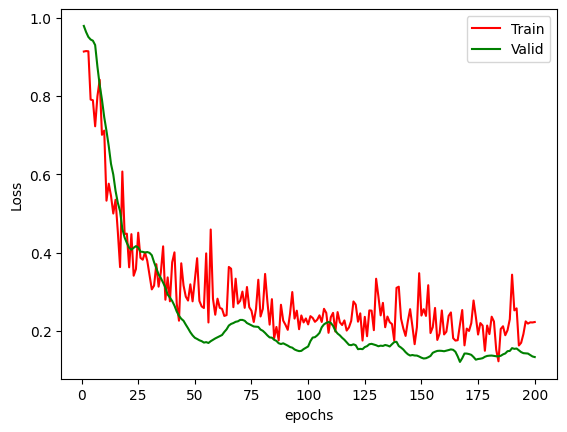

In [53]:
# plot the variation of train and validation losses vs n_epochs
loss=pd.read_csv('loss_epoch.csv',header=0,index_col=False)
plt.plot(loss['epoch'],loss['Training Loss'],'r',loss['epoch'],loss['Validation Loss'],'g')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend(labels=['Train','Valid'])
plt.savefig('loss_epoch.png')

##Load  a trained model

In [59]:
# load the model that got the minimum validation loss
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Generate predictions

###Visualize and save the inference results

fuck
fuck
fuck
fuck


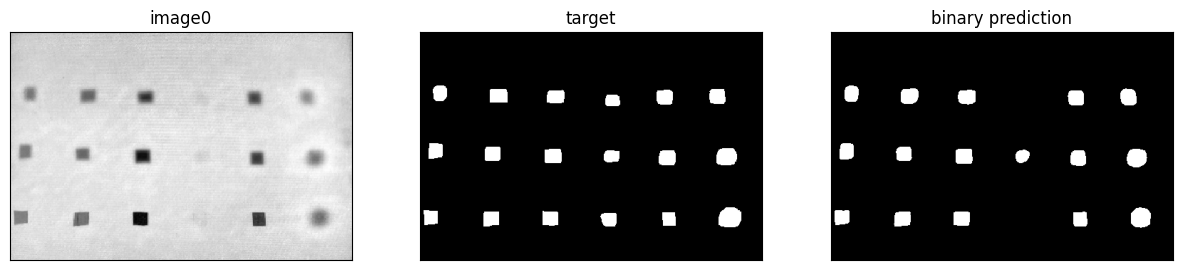

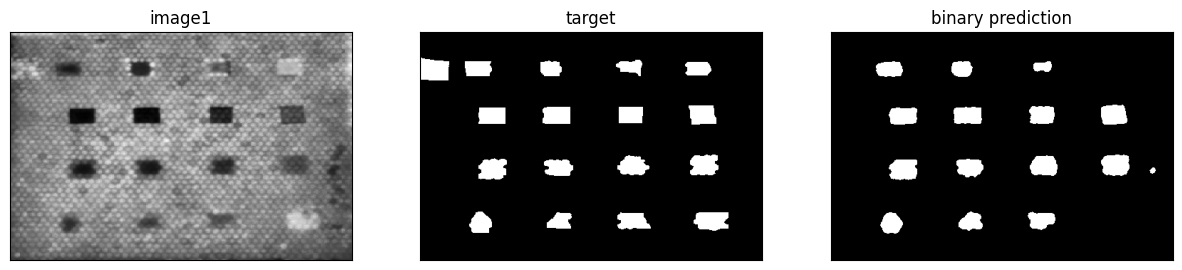

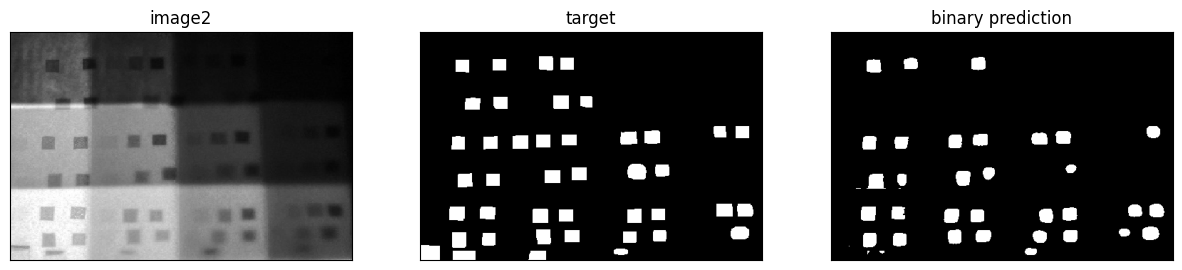

<Figure size 1500x400 with 0 Axes>

In [60]:
plot_prediction_results(model, train_on_gpu, loaders['test'], threshold)

###Get the inference performance metrics

In [56]:
df = get_inference_performance_metrics(model, train_on_gpu, loaders['test'], threshold)

fuck
fuck
fuck
fuck


In [57]:
###The inference performance metrics stats
df.describe()

,specificity,sensitivity,precision,F1_score,F2_score,DSC,F_beta,MAE,acc
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,0.518801,0.412934,0.491054,0.447105,0.425696,0.447105,0.469231,0.010807,0.510028
std,0.335306,0.308011,0.316093,0.313129,0.310248,0.313129,0.315067,0.003889,0.335579
min,0.248281,0.208758,0.235558,0.224380,0.218167,0.224380,0.230264,0.005662,0.244338
25%,0.310989,0.212850,0.294135,0.244103,0.222334,0.244102,0.268366,0.008867,0.300835
50%,0.414927,0.290669,0.393692,0.332172,0.304074,0.332172,0.362521,0.011801,0.402854
75%,0.622738,0.490753,0.590611,0.535175,0.507436,0.535175,0.563385,0.013741,0.612048
max,0.997068,0.861639,0.941274,0.899698,0.876470,0.899698,0.921617,0.013962,0.990065


In [58]:
#!pip install pipreqs
#!pipreqs
